**Table of contents**<a id='toc0_'></a>    
- 1. [Problem 1: Optimal taxation with government consumption](#toc1_)    
- 2. [Problem 2: Labor adjustment costs](#toc2_)    
- 3. [Problem 3: Global optimizer with refined multi-start](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [79]:
# Magic reload
%load_ext autoreload
%autoreload 2

# Import packages
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, root
from problem1 import optimaltax

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. <a id='toc1_'></a>[Problem 1: Optimal taxation with government consumption](#toc0_)


Consider a worker choosing hours of labor, $L\in[0,24]$, to maximize utility: 

$$
\begin{align*}
V(w,\tau,G)&=\max_{L\in[0,24]}\ln\left(C^{\alpha}G^{1-\alpha}\right)-\nu\frac{L^{2}}{2}\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}
$$

where 

* $C$ is *private* consumption with weight $\alpha\in(0,1)$.
* $\kappa > 0$ is the *free private* consumption component.
* $(1-\tau)wL$ is the *costly private* consumption component.
* $w > 0 $ is the real wage.
* $\tau \in (0,1)$ is the labor-income tax rate.
* $G > 0 $ is *government* consumption with weight $1-\alpha$.
* $\nu > 0$ is the disutility of labor scaling factor


The baseline parameters are:

$$
\begin{align*}
\alpha &= 0.5\\
\kappa &= 1.0\\
\nu &= \frac{1}{2\cdot16^2} \\
w &= 1.0 \\ 
\tau &= 0.30 \\
\end{align*}
$$

**Question 1:** Verify that the optimal labor supply choice is $L^{\star}(\tilde{w}) =\frac{-\kappa+\sqrt{\kappa^{2}+4\frac{\alpha}{\nu}\tilde{w}^2}}{2\tilde{w}}$, where $\tilde{w} = (1-\tau)w$, for $G\in\left\{1.0 , 2.0\right\}$.

Numeric and analytic solutions for G $\in$ {1.0, 2.0}

In [35]:
# Setup model for G = 1.0
G = 1.0
print('Solution for G =', G)
model = optimaltax()
model.par.G = G

# Numeric solution
print(f'Numeric solution:  {model.solve():.4f}')

# Analytic solution
w_tilde = model.par.w*(1-model.par.tau)
print(f'Analytic solution: {model.analytic_solution(w_tilde):.4f}')




# Setup model for G = 2.0
print('')
G = 2.0
print('Solution for G =', G)
model = optimaltax()
model.par.G = G

# Numeric solution
print(f'Numeric solution:  {model.solve():.4f}')

# Analytic solution
w_tilde = model.par.w*(1-model.par.tau)
print(f'Analytic solution: {model.analytic_solution(w_tilde):.4f}')

Solution for G = 1.0
Numeric solution:  15.3017
Analytic solution: 15.3017

Solution for G = 2.0
Numeric solution:  15.3017
Analytic solution: 15.3017


I verify that the numeric and analytic solutions are the same for G $\in$ {1.0, 2.0}, and notice that the solution doesn't depend on G.

**Question 2:** Illustrate how $L^{\star}(\tilde{w})$ depends on $w$.

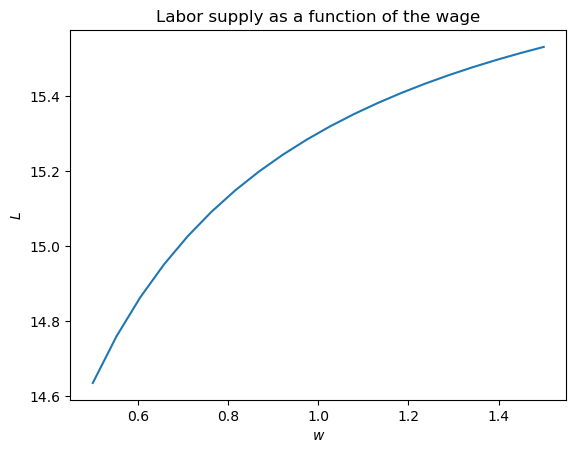

In [39]:
# Setup model for G = 1.0
model = optimaltax()

# Make w-grid and find corresponding L
w_grid = np.linspace(0.5,1.5,20)
w_tilde = w_grid*(1-model.par.tau)
L_grid = model.analytic_solution(w_tilde)

#Make figure of L(w)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(w_grid,L_grid)
ax.set_xlabel('$w$')
ax.set_ylabel('$L$')
ax.set_title('Labor supply as a function of the wage')
plt.show()


We now consider a government, who chooses $\tau$ and spend all of the taxes on government consumption so:

$$
G = \tau w L^{\star}((1-\tau)w)
$$

**Question 3:** Plot the implied $L$, $G$ and worker utility for a grid of $\tau$-values.


I solve the model for a range of tau values, and plot the implied L, G and worker utility.

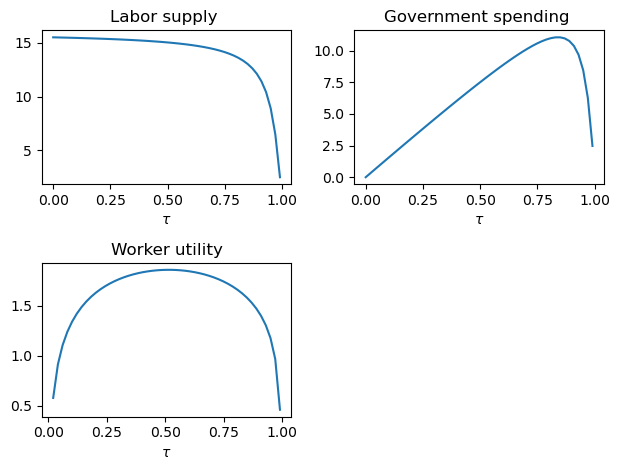

In [45]:
# Setup model for G = 1.0
model = optimaltax()

# make tau-grid
tau_grid = np.linspace(0.0,0.99,50)

# Allocate
L = np.empty_like(tau_grid)
G = np.empty_like(tau_grid)
U = np.empty_like(tau_grid)

# Solve model for each tau
for i, tau in enumerate(tau_grid):
    model.par.tau = tau
    w_tilde = model.par.w*(1-model.par.tau)
    L[i] = model.analytic_solution(w_tilde)
    G[i] = tau * model.par.w * L[i]
    U[i] = model.utility(model.BC_implied_C(L[i]), G[i], L[i])
    
# Make figure of L(tau), G(tau) and U(tau)
fig = plt.figure()
ax = fig.add_subplot(2,2,1)
ax.plot(tau_grid,L)
ax.set_xlabel('$\\tau$')
ax.set_title('Labor supply ')

ax = fig.add_subplot(2,2,2)
ax.plot(tau_grid,G)
ax.set_xlabel('$\\tau$')
ax.set_title('Government spending ')

ax = fig.add_subplot(2,2,3)
ax.plot(tau_grid,U)
ax.set_xlabel('$\\tau$')
ax.set_title('Worker utility')

plt.tight_layout()
plt.show()

**Question 4:** Find the socially optimal tax rate $\tau^{\star}\in(0,1)$ maximizing worker utility. Illustrate your result.

I find the socially optimal tax rate by maximizing worker utility, where I solve the model for each guess of tau. The socially optimal tax rate is illustrated in the figure above.

In [53]:
def objective(tau, model):
    """ Objective function """
    # Update tau
    model.par.tau = tau
    
    # Solve model
    w_tilde = model.par.w*(1-model.par.tau)
    L = model.analytic_solution(w_tilde)
    
    # Compute utility
    U = model.utility(model.BC_implied_C(L), tau*model.par.w*L, L)
    
    return -U

# Maximize utility
res = minimize(objective, x0=0.3, args=(model), method='Nelder-Mead', bounds=[(0,1)], tol=1e-10)

print(f'Socially optimal tax rate: {res.x[0]:.4f}')

Socially optimal tax rate: 0.5145


A more general preference formulation for the worker is:

$$
\begin{align*}
\mathcal{V}(w,\tau,G)&=\max_{L\in[0,24]}\frac{\left[ \left( \alpha C^{\frac{\sigma-1}{\sigma}}+(1-\alpha) G^{\frac{\sigma-1}{\sigma}} \right)^{\frac{\sigma}{1-\sigma} }\right]^{1-\rho}-1}{1-\rho}- \nu\frac{L^{1+\varepsilon}}{1+\varepsilon},\,\,\,\varepsilon,\rho,\sigma>0,\,\,\,\rho,\sigma\neq1\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}    
$$

Optimal labor supply is now $L^{\star}(\tilde{w},G)$.

Questions 5 and 6 must be answered with the general formulation, and for 2 different set of parameters:

- Set 1:  $\sigma = 1.001$, $\rho = 1.001$ and $\varepsilon = 1.0$.
- Set 2:  $\sigma = 1.5$, $\rho = 1.5$ and $\varepsilon = 1.0 $.

**Question 5:** Find the $G$ that solves $G = \tau w L^{\star}((1-\tau)w,G)$ using the $\tau$ found in question 4.

*Hint: First write code that solves the worker problem for given values of $G$ and $\tau$. Then find the correct G based on this.*

In [114]:
############## Set 1 ##############
model = optimaltax()
model.par.tau = 0.5145
model.par.sigma = 1.001
model.par.rho = 1.001
model.par.epsilon = 1.0

def obj_G(G,model):
    model.par.G = G
    L = model.solve(type = 'complex')
    new_G = model.par.tau * model.par.w * L
    res = new_G - G
    return res

res = root(obj_G, x0=1.0, args=(model), method='broyden1', tol=1e-10)

print(f'The G that solves the government consumption rule for set 1 is: {res.x:.4f}')

############## Set 2 ##############
model.par.sigma = 1.5
model.par.rho = 1.5

res = root(obj_G, x0=1.0, args=(model), method='broyden1', tol=1e-10)

print(f'The G that solves the government consumption rule for set 2 is: {res.x:.4f}')

The G that solves the government consumption rule for set 1 is: 7.7108
The G that solves the government consumption rule for set 2 is: 4.9750


**Question 6:** Find the socially optimal tax rate, $\tau^{\star}$, maximizing worker utility, while keeping $G = \tau w L^{\star}((1-\tau)w,G)$.

In [115]:
############## Set 1 ##############
model=optimaltax()
model.par.sigma = 1.001
model.par.rho = 1.001
model.par.epsilon = 1.0

def objective6(x):
    """ Objective function """
    
    # Unpack x
    tau, G = x
    
    # Update tau
    model.par.tau = tau
    
    # Solve model
    L = model.solve(type = 'complex')
    
    # Compute utility
    U = model.utility(model.BC_implied_C(L), G, L)
    
    return -U

# Maximize utility
res = minimize(objective6, x0=(0.3,1.0), method='SLSQP', bounds=[(0,1),(0,np.inf)], constraints=[{'type':'eq', 'fun': lambda x: x[1] - x[0] * model.par.w * model.solve(type = 'complex')}], tol=1e-10)

print(f'The socially optimal tax rate for set 1 is: {res.x[0]:.4f}')


############## Set 2 ##############
# Set parameters
model.par.sigma = 1.5
model.par.rho = 1.5

# Maximize utility
res = minimize(objective6, x0=(0.3,1.0), method='SLSQP', bounds=[(0,1),(0,np.inf)], constraints=[{'type':'eq', 'fun': lambda x: x[1] - x[0] * model.par.w * model.solve(type = 'complex')}], tol=1e-10)

print(f'The socially optimal tax rate for set 2 is: {res.x[0]:.4f}')

The socially optimal tax rate for set 1 is: 0.5150
The socially optimal tax rate for set 1 is: 0.5402


## 2. <a id='toc2_'></a>[Problem 2: Labor adjustment costs](#toc0_)

You own a hair salon. You employ hairdressers, $\ell_t$, to produce haircuts, $y_t = \ell_t$.

The wage for each haridresser is $w$.

The demand for haircuts implies that the price of haircuts you can charge is $p_t = \kappa_t y_t^{-\eta}$, where $\kappa_t$ is a demand-shock and $\eta \in (0,1)$ measures the elasticity of demand.

Profits are:

$$
\Pi_t = p_t y_t - w \ell_t = \kappa_t \ell_t^{1-\eta} - w \ell_t
$$

Baseline parameters are:
- $\eta = 0.5$
- $w = 1.0$

**Question 1:** Verify numerically that $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ maximises profits, for $\kappa\in\left\{1.0 , 2.0\right\}$.

In [8]:
# write your code here

We now consider a *dynamic* version of the model.

* The demand-shock is a so-called AR(1) in logs, 

$$
\log \kappa_{t} = \rho \log \kappa_{t-1} + \epsilon_{t},\,\,\, \epsilon_{t+1} \sim \mathcal{N}(-0.5\sigma_{\epsilon}^2,\sigma_{\epsilon})
$$

* Any hiring or firing implies a fixed adjustment cost, $\iota > 0 $.
* Future profits are discounted with a monthly factor of $R \in (0,1)$.

The initial demand shock is $\kappa_{-1} = 1$ and the planning horizon is 10 years, i.e. 120 months so $t \in \{0,1,2,\dots,119\}$. Initially you don't have any employees, $\ell_{-1}=0$


The *ex post* value of the salon is *conditional* on the shock series is:

$$
h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119}) = \left[\sum_{t=0}^{119}R^{-t}\left[\kappa_{t}\ell_{t}^{1-\eta}-w\ell_{t}-\boldsymbol{1}_{\ell_{t}\neq\ell_{t-1}}\iota\right]\right]
$$

The *ex ante* expected value of the salon can be approximated by

$$
H = \mathbb{E}[h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119})] \approx \frac{1}{K}\sum_{k=0}^{K} h(\epsilon_0^k,\epsilon_1^k,\dots,\epsilon_{119}^k)
$$

where each $k\in\{0,1,\dots,K-1\}$ is a random shock series. Maximizing profitability means maximizing $H$.


Baseline parameters are: 

- $\rho = 0.90$
- $\iota = 0.01$
- $\sigma_{\epsilon} = 0.10$
- $R = \left(1+0.01\right)^{1/12}$

**Question 2:** Calculate $H$ if the policy  $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ from question 1 is followed. Choose $K$ so the approximation is good enough to not affect your results substantially.

In [9]:
# write your code here 

Next, we consider policies on the form:

$$

\ell_{t}=\begin{cases}
\ell_t^{\ast}  & \text{if }\left|\ell_{t-1}-\ell_t^{\ast} \right|>\Delta\\
\ell_{t-1} & \text{else }
\end{cases}
\\
\text{where}\,\,\ell_t^{\ast} = \left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}} \\

$$
With $\Delta \geq 0$ and $\Delta = 0$ being the previous policy.



**Question 3:** Calculate $H$ if the policy above was followed with $\Delta = 0.05$. Does it improve profitability?

In [10]:
# write your code here

**Question 4:** Find the optimal $\Delta$ maximizing $H$. Illustrate your result.

In [11]:
# write your code here


**Question 5:** Suggest an alternative policy you believe might improve profitability. Implement and test your policy.



In [12]:
# write your code here

## 3. <a id='toc3_'></a>[Problem 3: Global optimizer with refined multi-start](#toc0_)

We consider the Griewank function:

$$ f(\boldsymbol{x}) = \sum^n_{i=1} \frac{x^2_i}{4000}-\prod^n_{i=1}\cos\left(\frac{x_i}{\sqrt{i}}\right)+1$$

The **global minimum** of this function is $f(0,0) = 0$ (remember: $\cos(0)=1$).<br>
But the function also have a lot of **local minima**.

In [13]:
def griewank(x):
    return griewank_(x[0],x[1])
    
def griewank_(x1,x2):
    A = x1**2/4000 + x2**2/4000
    B = np.cos(x1/np.sqrt(1))*np.cos(x2/np.sqrt(2))
    return A-B+1

A **refined global optimizer with multi-start** is:

1. Choose *bounds* for $\mathbf{x}$ and *tolerance* $\tau > 0$.
2. Choose number of *warm-up iterations*, $\underline{K} > 0$ and *maximum number of iterations*, $K > \underline{K}$.
3. In each iteration for $k \in \{0,1,\dots,K-1\}$:

    A. Draw random $\mathbf{x}^k$ uniformly within chosen bounds.

    B. If $k < \underline{K}$ go to step E.

    C. Calculate $\chi^k = 0.50\cdot\frac{2}{1+\exp((k-\underline{K})/100)}$  

    D. Set $\mathbf{x}^{k0} = \chi^k \mathbf{x}^k + (1-\chi^k)\mathbf{x}^{\ast} $

    E. Run optimizer with $\mathbf{x}^{k0}$ as initial guess and $\mathbf{x}^{k\ast}$ as result.

    F. Set $\mathbf{x}^{\ast} = \mathbf{x}^{k\ast}$ if $k = 0$ or $f(\mathbf{x}^{k\ast}) < f(\mathbf{x}^{\ast})$

    G. If $f(\mathbf{x}^{\ast}) < \tau$ go to step 4.

4. Return the result $\mathbf{x}^{\ast}$.

As settings we choose:

* $x_1,x_2 \in  [-600,600]$
* $\tau = 10^{-8}$
* $\underline{K}=10$
* $K=1000$

The optimizer in Step 3.E is `BFGS` with a tolerance of $\tau$.

**Question 1:** Implement the refined global optimizer with multi-start. Illustrate how the effective initial guesses $\mathbf{x}^{k0}$ vary with the iteration counter $k$.

In [14]:
# write your code here

**Question 2:** Is it a better idea to set $\underline{K} = 100$? Is the convergence faster?

In [15]:
# write your code here